# Imports

In [ ]:
! python --version

Python 3.7.10


In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
!pip install tensorflow_hub


In [ ]:
!pip install keras tf-models-official pydot graphviz

     |████████████████████████████████| 1.6MB 8.5MB/s 
     |████████████████████████████████| 1.2MB 49.6MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 38.2MB 76kB/s 
     |████████████████████████████████| 358kB 51.5MB/s 
     |████████████████████████████████| 102kB 15.1MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 174kB 55.2MB/s 
     |████████████████████████████████| 686kB 28.4MB/s 
     |████████████████████████████████| 454.3MB 38kB/s 
     |████████████████████████████████| 6.0MB 38.1MB/s 
     |████████████████████████████████| 4.0MB 39.5MB/s 
     |████████████████████████████████| 1.2MB 32.0MB/s 
     |████████████████████████████████| 471kB 42.9MB/s 
     |████████████████████████████████| 4.9MB 36.0MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=91e79a482625a242920cd2e76197cc5933ee7e75015a08048781a4d9e4de3830
  Stored in d

In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Data

For this example you need to download twitter data from Kaggle: https://www.kaggle.com/kazanova/sentiment140

Context \\
\
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment. \\
\
Content \\
\
It contains the following 6 fields:
* target: the polarity of the tweet (0 = negative, 4 = positive)

* ids: The id of the tweet ( 2087)

* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

* flag: The query (lyx). If there is no query, then this value is NO_QUERY.

* user: the user that tweeted (robotickilldozr)

* text: the text of the tweet (Lyx is cool)

Acknowledgements \\
The official link regarding the dataset with resources about how it was generated is [here](http://%20http//help.sentiment140.com/for-students/) \\
The official paper detailing the approach is [here](http://bhttp//cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)

Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

In [ ]:
#df = pd.read_csv('training.csv')
df = pd.read_csv('haha_2021_train.csv')
df.shape

(24000, 12)

In [ ]:
df.head()

,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,humor_rating,humor_mechanism,humor_target
0,tweet1,Niveles de retraso mental: \n\n— Bajo.\n— Medi...,1,1,2,2,0,0,0,1.5,NaN,NaN
1,tweet2,"—Vamos Luke desenfunda tu sable, demuestra tu ...",1,1,3,0,1,0,0,1.5,NaN,NaN
2,tweet3,"- ¿Te ofrezco algo?, ¿Agua, café, mi corazón, ...",1,0,2,1,0,1,1,2.6,NaN,NaN
3,tweet4,No se porqué me hago la cabeza deooos,0,3,0,0,0,0,0,NaN,NaN,NaN
4,tweet5,Quisiera saber que hago durante la siesta de l...,0,4,0,1,0,0,0,NaN,NaN,NaN


We have two classes in the dataset

In [ ]:
df.is_humor.unique()

array([1, 0])

Let's check how equally distributed those classes are.

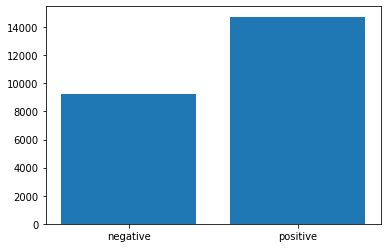

In [ ]:
classes = df.is_humor.unique()
counts = []

for i in classes:
  count = len(df[df.is_humor==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

Even class distribution helps us a lot in text classifiction. Imagine a situation where 95% of data is in one class and the rest 5% is split among other 5 classes. If we wouldn't do anything about it model would just learn to guess the 95% class all the time and would be correct 95% of the time on the data we would use.

To start modelling we still need to do a couple of things:

1.   Split data into train and test datasets
2.   Encode labels
3.   Tokenize text



## Train/test split

We don't really need all 1.6 Million tweets for training so we can take a sample of 5% (to save up time on training) and then split that into 80% for training and 20% for testing.

In [ ]:
# sample_size = int(len(df)*0.75)
# sampleDf = df.sample(sample_size, random_state=23)
x = df.text.values
y = df.is_humor.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

## Label Encoding

We could get away with other approach but you might want to use this for more than binary classification.

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

We might want to use encoding for later. For that we can save enconding map.

In [ ]:
# encoder_fname = 'twitter_classes.npy'
# my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'
# np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

To load it when you'll use this in production just use the below cell (uncommented ofcourse)

In [ ]:
# encoder = LabelEncoder()
# encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

## Tokenization

To tokenize our text we will use some functions from official.nlp.bert package and the pretrained [BERT](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270) model itself. \\
First we get the BERT model. I'll use the multilingual one as it will be best for most of your cases. To check all NLP models provided by TF HUB go [here](https://tfhub.dev/s?module-type=text-embedding,text-classification,text-generation,text-language-model,text-question-answering,text-retrieval-question-answering).

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

You can see that in above cell we have loaded some variables using the bert_layer we have downloaded. 

1.   ```vocab_file``` reads the vocab file associated to the downloaded model.
2.   ```do_lower_case``` reads binary variable which if ```True``` means tokenizer will reformat all text to lower case rendering model to be **NOT** case sensitive. Should be ```False``` by default. You can check in a cell below.
3.   ```tokenizer``` builds tokenizer using variables 1 and 2.



In [ ]:
do_lower_case

False

Lastly we need to add two additional tokens: Classification and Seperation. We will add these through functions we will use to tokenize our text.

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Kewl, by this point we have everything for tokenization. This will take a bit as we have quite a bit of data.

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized Tweets shape', tweets.shape.as_list())

Tokenized Tweets shape [19200, None]


This is to what our tweets have converted to. The ids there are essentially the same as in the simple NN example we did last time, just this time we use a predefined vocabulary.


In [ ]:
tweets[0]

<tf.Tensor: shape=(21,), dtype=int32, numpy=
array([  162, 10126, 63790, 47441,   169, 16286, 72132, 10121, 13321,
       13321,   117, 10312, 15289, 17672, 13420, 10107, 71290, 46113,
       52205, 13321,   102], dtype=int32)>

If you want to see how tokenizer does the "tokenizing" check the cells below.

In [ ]:
x_train[0]

'Y se mandaban a esas fiestas queeeee, son todas ratasss tomando champagneee'

In [ ]:
tokenizedTweet = tokenizer.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizer.convert_tokens_to_ids([i]))

Y [162]
se [10126]
mand [63790]
##aban [47441]
a [169]
esas [16286]
fiestas [72132]
que [10121]
##ee [13321]
##ee [13321]
, [117]
son [10312]
todas [15289]
rata [17672]
##ss [13420]
##s [10107]
tomando [71290]
champ [46113]
##agne [52205]
##ee [13321]


We still need to add classification token.

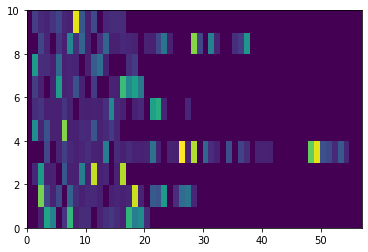

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

What you see above is a graphical representation of our tokenized tweets. First token is our classification token. Other colored blocks than background are other tokens. And background, well that's just padding.

## Mask and input type

The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

In [ ]:
input_word_ids

<tf.RaggedTensor [[101, 162, 10126, 63790, 47441, 169, 16286, 72132, 10121, 13321, 13321, 117, 10312, 15289, 17672, 13420, 10107, 71290, 46113, 52205, 13321, 102], [101, 224, 86462, 22252, 10347, 23964, 117, 34401, 13386, 10110, 12132, 12088, 10125, 108, 10247, 11490, 10112, 11565, 100657, 10567, 136, 30665, 27920, 58775, 119, 14036, 38329, 42396, 11827, 119, 102], [101, 11589, 59227, 10216, 10285, 189, 29427, 10104, 10182, 46813, 10183, 99276, 10113, 11675, 117, 10543, 96646, 102], [101, 100, 199, 22800, 106, 10795, 20401, 12306, 10192, 11202, 14412, 10478, 10164, 46063, 100, 12882, 10157, 13055, 10374, 10113, 10824, 40230, 10219, 193, 10361, 10173, 109445, 10119, 96309, 100, 35921, 13739, 10119, 177, 26232, 100, 21434, 13672, 171, 10246, 10545, 10121, 119, 119, 119, 100, 199, 154, 83259, 104737, 26578, 24124, 12396, 30118, 11259, 106, 102], [101, 53417, 10835, 27111, 10107, 10220, 89304, 10171, 10110, 13055, 12088, 28434, 10611, 12368, 17958, 11395, 119, 102], [101, 13497, 16649, 101

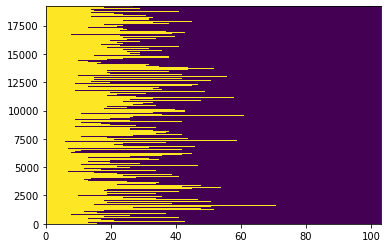

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

Here each yellow block has some input. We just make this for the model to differ between padding and input.

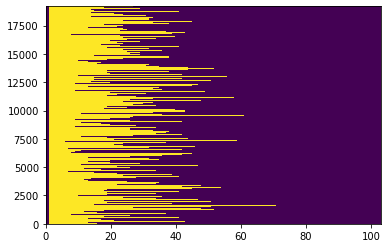

In [ ]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tweets)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

It's hard to see but we added an empty block in front of each tweet for the `[CLS]` token. Check tensor below

In [ ]:
input_type_ids

<tf.Tensor: shape=(19200, 103), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

## Remake into a function for normal use

So at this point we have all of our three inputs:

1.   Tokens
2.   Input mask
3.   Input type

It will make our work easier both now and in the future if we remake everything into funcitons.



First let's set the max sequence lenght as we did in simple NN example.

In [ ]:
lens = [len(i) for i in input_word_ids]

In [ ]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 103


Most of the time I suggest adding a bit more to the `max_seq_length` esspecially when ussing just a fraction of data. Let's make it `1.5*max_seq_length`.

In [ ]:
max_seq_length = int(1.5*max_seq_length)
print('Max length is:', max_seq_length)

Max length is: 154


Functions themselves.

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

And now we preprocess inputs.

In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

# Bam MODEL part already

## Initial training

We need to set up our model using the inputs we made, BERT model that we downloaded and an output layer based on num of classes we are using.

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

Our model.

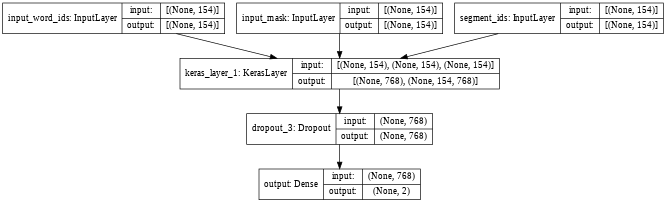

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

Set up the training parameters.

In [ ]:
epochs = 3
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Compile the model.

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 154)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 154)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 154)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

Set up a history to check our model performance afterwards.

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1200/1200 [==============================] - ETA: 0s - loss: 0.4721 - accuracy: 0.7592WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fd9ae0577a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1200/1200 [==============================] - 763s 621ms/step - loss: 0.4720 - accuracy: 0.7593 - val_loss: 0.3286 - val_accuracy: 0.8590
Epoch 2/3
1200/1200 [==============================] - 743s 619ms/step - loss: 0.2941 - accuracy: 0.8802 - val_loss: 0.3417 - val_accuracy: 0.8673
Epoch 3/3
1200/1200 [==============================] - 743s 619ms/step - loss: 0.2004 - accuracy: 0.9268 - val_loss: 0.4612 - val_accuracy: 0.8621


Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9643
Testing Accuracy:  0.8621


Noice plots are noice

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

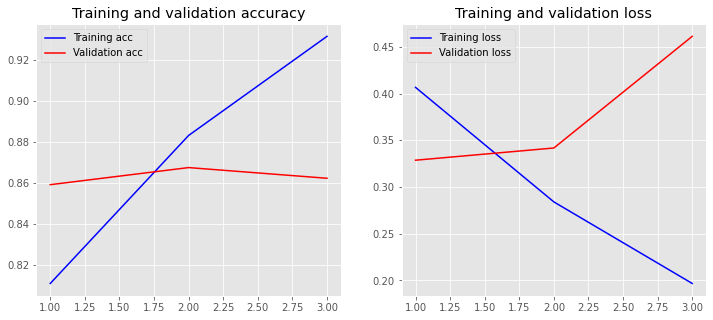

In [ ]:
plot_history(history)

So, looking at the plot above we can see that at the 3rd epoch our `Validation Loss` jumped significantly even though `Validation Accuracy` stayed pretty much the same. If we would train it more on the same data it would significantly overtrain. \\
What we can do instead is make another training dataset, lower our learning rate commonly denoted as `lr`, recompile our model using new `lr` and then train it a bit more. \\
But before doing that we should save our model just in case if we would want to do the additional training in later sessions.

## Model saving for later use

Let's save our model for later use. Unfortunatelly we can't use the optimizer we used for model training to save. I get an error and I can't resolve it. So we will recompile our model before saving.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

model.save(os.path.join(my_wd, model_fname))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: /content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/twitter_BERT/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/twitter_BERT/assets


### Validate saved model

Sometimes TF likes to corrupt your model when saving. It's always a good idea to check if everything loads correctly after save.

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Testing Accuracy:  0.8621


In [ ]:
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 154)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 154)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 154)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

For safety reasons I would check the tokenizer variables as well.

In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

If this loads, you should be fine.

In [ ]:
tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

Y [162]
se [10126]
mand [63790]
##aban [47441]
a [169]
esas [16286]
fiestas [72132]
que [10121]
##ee [13321]
##ee [13321]
, [117]
son [10312]
todas [15289]
rata [17672]
##ss [13420]
##s [10107]
tomando [71290]
champ [46113]
##agne [52205]
##ee [13321]


As everything seems fine, we can move on to second training itteration and try to make our model a bit better.

## Second training itteration

In [ ]:
plot_history(history)

As mentioned before, looking at the plot above we can see that at the 3rd epoch our `Validation Loss` jumped significantly even though `Validation Accuracy` stayed pretty much the same. If we would train it more on the same data it would significantly overtrain. \\

What we can do instead is make another training dataset, lower our learning rate commonly denoted as `lr`, recompile our model using new `lr` and then train it a bit more.

Are there any other options to approach overtraining? Sure. One of the most obvious ways would be to increase dropout layer number or the dropout precentage. You could try playing around with pooling as well, but in essence dropout would be your go to. 

If you do not know what dropout is then in short it 'turns off' preceeding layer neurons before next layer calculation, thus increasing the need for the model to 'abstract' things it sees.

Anyway, in our case we are doing `lr` change and adding new data for the model. Let's see how that goes.

### Data

First we need to prep our data. It's good that we made our processing easier making some functions. Let's take another 5% sample from our data.

In [ ]:
sample_size = int(len(df)*0.05)
sampleDf = df.sample(sample_size, random_state=42)  # notice the random state changes
x = sampleDf.text.values
y = sampleDf.target.values
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.20, random_state=42)  # notice the random state changes

In [ ]:
classes = sampleDf.target.unique()
print(classes)
counts = []

for i in classes:
  count = len(sampleDf[sampleDf.target==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

It's not a bad idea to always check if your sample is representitive of the dataset itself. Most of the time it will, but when getting small samples it might be off in small datasets.

#### Label Encoding
Now we need to encode labels again. Good thing we have our label encoder saved.

In [ ]:
encoder_fname = 'twitter_classes.npy'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

encoded_Y_test2 = encoder.transform(y_test2)
encoded_Y_train2 = encoder.transform(y_train2)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test2 = np_utils.to_categorical(encoded_Y_test2)
dummy_y_train2 = np_utils.to_categorical(encoded_Y_train2)

#### Input preprocessing
As we did before we need to tokenize our inputs (tweets) as `input_word_ids` and then add `input_mask` and `input_type`. As we saved our model, we can use it to build our tokenizer as it was.

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

I repaste our encoding functions here so it would be easier to follow.

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

As you can see in the functions we use max_seq_length to convert our tweets into inputs. We can't really change it from the one used to build our model as it is in the model structure itself. See below.

In [ ]:
print('Max sequence length is:', max_seq_length)

In [ ]:
model.summary()

You can see that all of the `InputLayers` have a shape of (0, 240) which is (0, `max_seq_length`). For that reason we must use the same `max_seq_length` for our model to understand the inputs it gets.

Now we will use the above functions to make all 3 of our inputs.

In [ ]:
X_train2 = bert_encode(x_train2, tokenizerSaved, max_seq_length)
X_test2 = bert_encode(x_test2, tokenizerSaved, max_seq_length)

In [ ]:
x_train2[0]

### Training

Firstly let's load our saved model.

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))
new_model.summary()

In [ ]:
tf.keras.utils.plot_model(new_model, show_shapes=True, dpi=48)

To check training progress we can use the new and the old testing datasets. Their accuracy should be close. Let's see how it compares.

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)  # OLD
print("Old testing Accuracy:  {:.4f}".format(accuracy))

loss, accuracy = new_model.evaluate(X_test2, dummy_y_test2, verbose=False)  # NEW
print("New testing Accuracy:  {:.4f}".format(accuracy))

As you can see there's some difference. In any case, I suggest you use the same testing sample to proceed with you training no matter if the accuracy is the same. This of course applies only to when you do not train on the full dataset.

We need to setup our training parameters again.

In [ ]:
epochs = 3
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train2)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

Now the optimizer we use has learing rate decay in it. Which means learning rate goes down over time by the set parameters. We can lower the initial learning rate for this training session or we could use other optimizer with a fixed learning rate altogether.

In [ ]:
optimizer = nlp.optimization.create_optimizer(
    2e-6, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Let's compile our model.

In [ ]:
new_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

And now finally we can train again and see if that helps us achieve a better accuracy.

In [ ]:
history2 = new_model.fit(X_train2,  # using new training set
                         dummy_y_train2,  # using new training set
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_data=(X_test, dummy_y_test),  # using old test dataset
                         verbose=1)

Let's plot everything out.

In [ ]:
for i in history2.history:
  for ele in history2.history[i]:
    history.history[i].append(ele)

In [ ]:
plot_history(history)

Our lines aren't consistent as we changed the training dataset. However, you can see that both the `val_accuracy` and `val_loss` improved. At his point we could itterate again and improve the model a bit more and more. Just understand that every incrimental improvement will take more data/time as it significantly slows down over time.

# Is BERT worth it?

So is BERT worth. BERT is a huge model compared to our simple NN and Logistic Regression models we used before. Is the increase in accuracy impactful enough compared to the increase in computation needed? Let's comapre accuracy:


1.   Logistic Regression 0.80
2.   Simple NN           0.79
3.   Finetuned BERT      0.84

In this case it totally depends on you. I personaly would say let's use Logistic Regression. Easily deployable, low computational resources and the task isn't that signicificant in terms of a mistake. If your goal is maximum accuracy possible I would train BERT a bit more and try to get to at least 85%, that would be significant enough to use BERT instead a much less computationaly intesnive Logistic Regression.



# Test

We need to check in with our label encoder to get our classes.

In [ ]:
encoder_fname = 'twitter_classes.npy'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

This is how our classes are encoded for the model.

In [ ]:
encoder.classes_

array([0, 1])

Input preprocessing.

In [ ]:
tweet = ['¿Tenés un mapa? -DE QUÉ? -De tus ojos, porque si no me pierdo en tu mirada - AYYY EN SERIO? -Naa era mentira, físico-político de América #XD']
inputs = bert_encode(string_list=list(x), 
                     tokenizer=tokenizerSaved, 
                     max_seq_length=154)

Prediction.

In [ ]:
prediction = new_model.predict(inputs)
print(prediction)
#print('Tweet is', 'positive' if encoder.classes_[np.argmax(prediction)]==1 else 'negative')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[0.00952426 0.9904757 ]
 [0.9957695  0.00423058]
 [0.00261488 0.9973851 ]
 ...
 [0.9975091  0.00249082]
 [0.09142226 0.9085778 ]
 [0.5345619  0.4654381 ]]


In [ ]:
arr1=[]
for i in prediction:
  if(i[0]<i[1]):
    arr1.append(1)
  else:
    arr1.append(0)

  

In [ ]:
inputs

{'input_mask': <tf.Tensor: shape=(1, 240), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1, 240), dtype=int32, numpy=
 array([[0, 1, 1, 1, 1, 1, 

In [ ]:
df1=pd.read_csv("testing.csv")
df1.shape
x = df1.Text.values
y = df1.is_humor.values

FileNotFoundError: ignored

In [ ]:
temp=(arr1 == y).astype(int)
sum(temp)/len(temp)


0.79875

qefljaei

In [ ]:
df2=pd.read_csv("haha_2021_dev.csv")
df2.shape
x = df2.text.values


In [ ]:
df2["is_humor"]=arr1
df2.to_csv("s4.csv")

In [ ]:
df2


,id,is_humor
0,tweet24001,1
1,tweet24002,0
2,tweet24003,1
3,tweet24004,0
4,tweet24005,0
...,...,...
5995,tweet29996,0
5996,tweet29997,0
5997,tweet29998,0
5998,tweet29999,1
